In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random
from scipy.stats import truncnorm

In [2]:
def get_sin(length, height):
    t = np.linspace(0, 4*np.pi, length)
    sine_wave = 20 * np.sin(t)
    sine_wave += height
    return sine_wave

def get_step(length, height):
    steps_y = [0, 10, 20, 30, 40]
    steps_x = length // len(steps_y)
    data = [np.full(shape=steps_x, fill_value=step) for step in steps_y]
    data = np.concatenate(data) + height
    if len(data) < length:
        # fill last values
        fill_len = length-len(data)
        fill_value = steps_y[-1] + height
        data = np.concatenate([data, np.full(shape=fill_len, fill_value=fill_value)])
    return data

def get_ramp(length, height):
    return np.arange(length) + height


def get_parabola(length, height):
    x = np.linspace(-5, 5, length)
    return (x**2) + height

def moving_average(x, w):
    mva = np.convolve(x, np.ones(w), 'valid') / w
    fill = np.full(shape=len(x)-len(mva), fill_value=mva[-1])
    return np.concatenate([mva, fill])

In [3]:
coin_toss = {
    0: get_sin,
    1: get_step,
    2: None
}

pattern_fn_map = {
    'sin': get_sin,
    'step': get_step,
    # 'ramp': get_ramp
}

def generate_timeseries(length, pattern=None, pattern_height=None, noise_std=0):
    timeseries = moving_average(np.random.normal(0, 50, length), w=7)
    pattern_length = int(length * 0.2)

    if pattern == 'regular':
        return timeseries
    
    elif pattern == 'combo':
        # first pattern
        coin = random.randint(0, 1)
        pattern_start = np.random.randint(0, length - 2*pattern_length)
        fn = coin_toss[coin]
        pattern_end = pattern_start + pattern_length

        pattern_patch = fn(pattern_length, pattern_height[0])
        if noise_std:
            pattern_patch += np.random.normal(0, noise_std, pattern_length)        
        timeseries[pattern_start:pattern_end] = pattern_patch

        # second pattern
        fn = coin_toss[1 - coin]
        pattern_start = np.random.randint(pattern_end, length - pattern_length)
        pattern_end = pattern_start + pattern_length
        
        pattern_patch = fn(pattern_length, pattern_height[1])
        if noise_std > 0:
            pattern_patch += np.random.normal(0, noise_std, pattern_length)        
        timeseries[pattern_start:pattern_end] = pattern_patch
    
    else:
        fn = pattern_fn_map[pattern]
        pattern_start = np.random.randint(0, length - pattern_length)
        pattern_end = pattern_start + pattern_length
        pattern_patch = fn(pattern_length, pattern_height[0])
        if noise_std:
            pattern_patch += np.random.normal(0, noise_std, pattern_length)   
        timeseries[pattern_start:pattern_end] = pattern_patch

    return timeseries

In [4]:
def get_truncated_normal(len, mean=0.5, sd=.2, low=0, upp=1):
    return truncnorm(
        (low - mean) / sd, (upp - mean) / sd, loc=mean, scale=sd).rvs(len)

In [5]:
def get_error_dist(i, length):
    sd = random.uniform(0.025, .1)
    if i%2 == 0:
        mean = random.uniform(0.825, 0.925)
        return get_truncated_normal(len=length, mean=mean, sd=sd, low=0, upp=1)

    else:
        mean = random.uniform(0.075, 0.175)
        return get_truncated_normal(len=length, mean=0.1, sd=sd, low=0, upp=1)
       
# pat_error = get_truncated_normal(len=PATTERN_SERIES, mean=0.9, sd=0.05, low=0, upp=1)
# step_error = get_truncated_normal(len=STEP_SERIES, mean=0.1, sd=0.05, low=0, upp=1)

In [6]:
patterns = {
    "combo": 200
}

In [7]:
TS_LEN = 150
REGULAR_SERIES = 2000

def generate_dataset(noise_std):
    
    # Regular population timeseries
    reg_height = np.random.normal(0, 25, REGULAR_SERIES)
    reg_error = get_truncated_normal(
        len=REGULAR_SERIES, mean=0.5, sd=0.1, low=0, upp=1)

    reg_labels = []
    reg_timeseries = []
    
    for i, height in enumerate(reg_height):
        dice =  i % 20
        if dice < 2:
            pattern = 'sin'
        elif dice < 4:
            pattern = 'step'
        else:
            pattern = 'regular'
            
        reg_labels.append(pattern)
        reg_timeseries.append(
            generate_timeseries(TS_LEN, pattern, [height], noise_std=noise_std)
        )

    reg_data = np.c_[ np.array(reg_timeseries), reg_error, reg_labels]

    
    # Combo pattern 
    patterns_data = None

    for i, (pattern, n) in enumerate(patterns.items()):
        if pattern=="combo": 
            pat_height = np.random.normal(0, 25, 2*n)
        else:
            pat_height = np.random.normal(0, 25, n)
        
        pat_error = get_error_dist(i, length=n)
        pat_labels = np.c_[ pat_error, np.full((n,), pattern) ]
        pat_timeseries = []

        for j in range(n):                        
            if pattern=="combo": 
                h1 = pat_height[2*j]
                h2 = pat_height[2*j + 1]
                h = [h1, h2]
            else:
                h = [pat_height[j]]
                
            pat_timeseries.append(
                generate_timeseries(
                    TS_LEN, pattern=pattern, 
                    pattern_height=h, noise_std=noise_std
                )
            )
        
        j_data = np.c_[ np.array(pat_timeseries), pat_labels ]
        
        if patterns_data is None:
            patterns_data = j_data
        else:
            patterns_data = np.r_[ patterns_data, j_data ]
        
    full_data = np.r_[ reg_data, patterns_data ]
    columns = list(range(0, TS_LEN)) + ['error', 'label']
    df = pd.DataFrame(full_data, columns=columns)

    numcols = columns[:-1]
    df[numcols] = df[numcols].apply(pd.to_numeric, axis=1)
    return df

In [8]:
def plot_random_series_helper(df):
    random_row = df.sample()
    datapoints = random_row.drop(columns=['label', 'error'])
    plt.plot(datapoints.values.flatten()[0:TS_LEN])
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.show()

In [9]:
def plot_error_distributions(df):
    bins = np.linspace(0, 1, 50)
    for lb in df['label'].value_counts().index:
        plt.hist(df[df['label']==lb]['error'], bins, alpha=0.5, label=lb)
    plt.legend(loc='upper right')
    plt.show()

### FIXED-Y, NO NOISE
200 series, half with sin

In [10]:
noise_std = 1
df = generate_dataset(noise_std=noise_std)

In [11]:
df.label.value_counts()

label
regular    1600
sin         200
step        200
combo       200
Name: count, dtype: int64

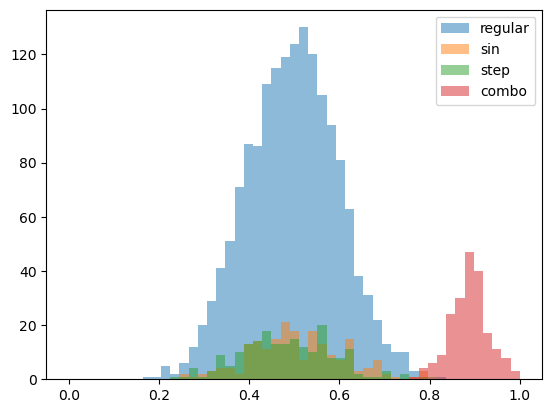

In [ ]:
plot_error_distributions(df)

regular


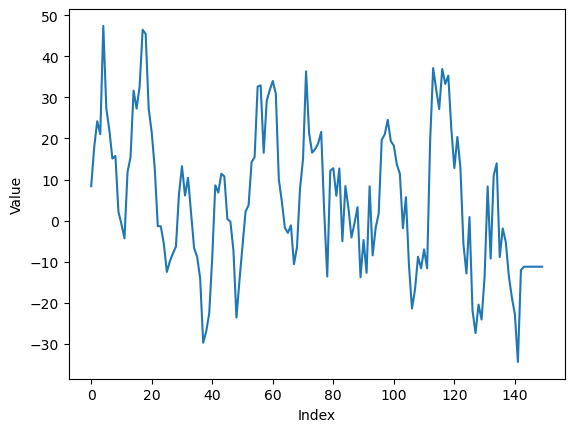

sin


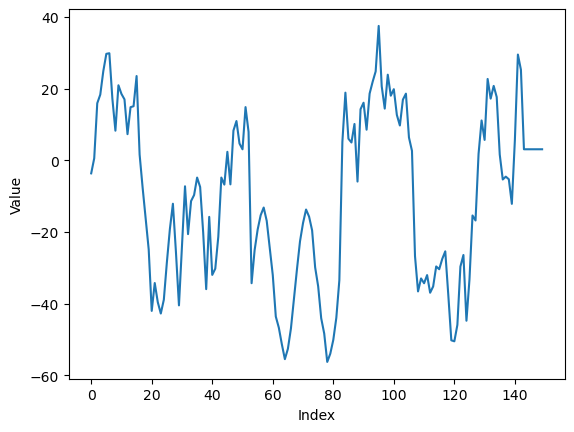

step


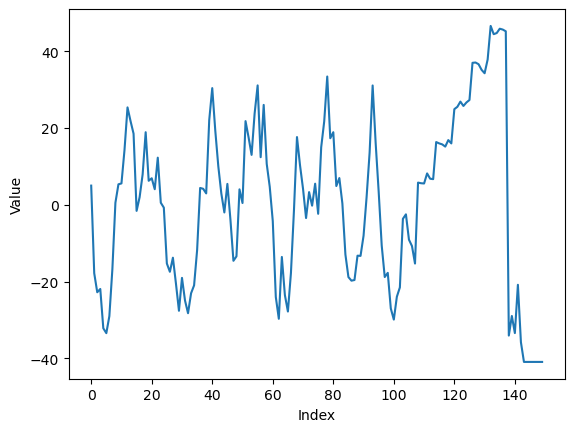

combo


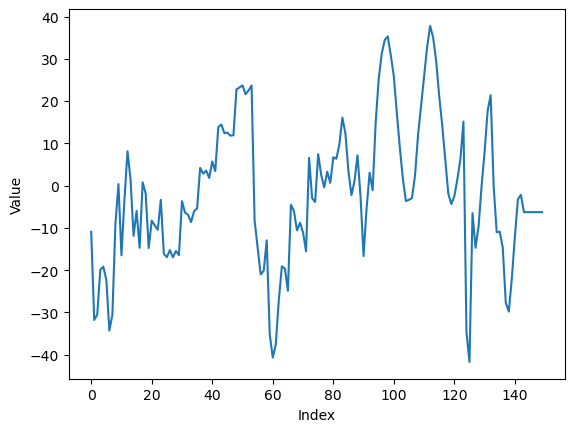

In [13]:
for lb in df['label'].value_counts().index:
    print(lb)
    plot_random_series_helper(df=df[df['label']==lb])

In [14]:
df = df.sample(frac=1).reset_index(drop=True)

df.to_csv(f'./data/combo_patterns_noise_{noise_std}.csv', index=False)